In [2]:
from pathlib import Path
import sys

# Detect repo root: parent of ./notebooks
repo = Path.cwd().resolve()
if repo.name == "notebooks":
    repo = repo.parent
sys.path.append(str(repo))

from src.parsing.runners import process_all_raw_recursive
from src.warehouse.db_build import build_warehouse, build_timeline_dataset
from src.parsing.runners import process_all_raw_recursive  # nombre según tu módulo



out = process_all_raw_recursive(
    raw_root   = repo / "data" / "00_raw",
    meta_root  = repo / "data" / "01_metadata",
    schema     = repo / "config" / "procedures.yml",
    overwrite  = True,
    verbose    = True,
)
print(out)


info = build_warehouse(
    meta_root  = repo / "data" / "01_metadata",
    out_root   = repo / "data" / "02_warehouse",
    overwrite  = True,
    verbose    = True,
    pin_schema = True,   # recomendado
)
print(info)

build_timeline_dataset(
    meta_root = repo / "data" / "01_metadata",
    out_root  = repo / "data" / "02_warehouse",
    overwrite = True,
    verbose   = True,
)






[discover] raw_root=/home/mphstphls/python-lab/data/00_raw dirs_with_csv=692
[process] /home/mphstphls/python-lab/data/00_raw/LabComputer1/data/2023-06-09
[parse_folder] base_dir=/home/mphstphls/python-lab/data/00_raw/LabComputer1/data/2023-06-09 csvs_found=5
[parse_header] IVg2023-06-09_13.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_14.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_16.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_17.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_18.csv: proc=IVg start_time=315543600.0 fields=21
[ok] wrote /home/mphstphls/python-lab/data/01_metadata/LabComputer1/data/2023-06-09/metadata.csv rows=5
[process] /home/mphstphls/python-lab/data/00_raw/LabComputer1/data/2023-06-13
[parse_folder] base_dir=/home/mphstphls/python-lab/data/00_raw/LabComputer1/data/2023-06-13 csvs_found=9
[parse_header] IVg2023-06-13_1.csv: proc=IVg start_time=31

{'parts': 0,
 'timelines_path': '/home/mphstphls/python-lab/data/02_warehouse/timelines'}

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.dates as mdates
import datetime as dt
import polars as pl
import matplotlib.pyplot as plt
from src.ploting.styles import set_plot_style
set_plot_style("prism_rain")


/tmp/ipykernel_15581/1364738080.py:25: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  counts.pivot(values="n", index="day", columns="proc", aggregate_function="sum")


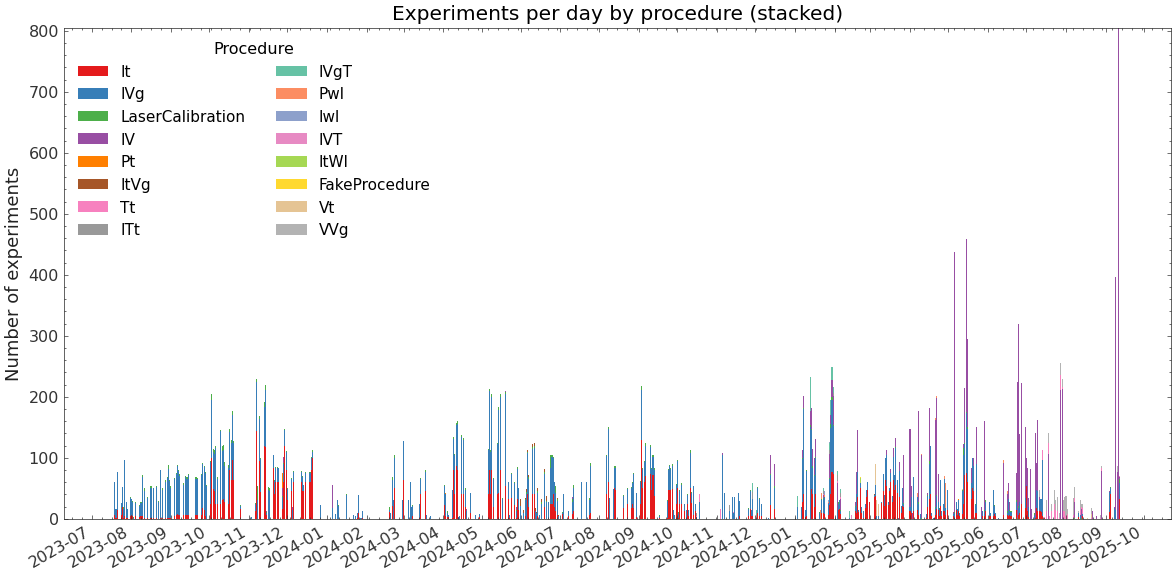

In [6]:

# Resolve repo root (works whether you're in ./ or ./notebooks)
repo = Path.cwd().resolve()
if repo.name == "notebooks":
    repo = repo.parent

# 1) Scan all parquet partitions from your warehouse
parquet_glob = str(repo / "data" / "02_warehouse" / "experiments" / "**" / "part-*.parquet")
lf = pl.scan_parquet(parquet_glob, extra_columns="ignore")

# 2) Group counts per day×procedure (filter from 2023-01-01)
counts = (
    lf.with_columns(pl.col("start_dt").dt.truncate("1d").alias("day"))
      .filter(pl.col("day") >= dt.datetime(2023, 1, 1))
      .group_by(["day", "proc"])
      .agg(pl.len().alias("n"))
      .sort("day")
      .collect()
)

if counts.height == 0:
    print("No data matched the filter (check your warehouse path or date filter).")
else:
    # 3) Pivot to wide format (one column per procedure)
    pivot = (
        counts.pivot(values="n", index="day", columns="proc", aggregate_function="sum")
              .fill_null(0)
              .sort("day")
    )

    days  = pivot.get_column("day").to_list()
    procs = [c for c in pivot.columns if c != "day"]
    series_by_proc = {p: pivot.get_column(p).to_list() for p in procs}

    # 4) Plot stacked bars
    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = [0]*len(days)
    for p in procs:
        vals = series_by_proc[p]
        ax.bar(days, vals, bottom=bottom, label=p)
        bottom = [b+v for b, v in zip(bottom, vals)]

    # 5) Nice date formatting + labels
    ax.set_ylabel("Number of experiments")
    ax.set_title("Experiments per day by procedure (stacked)")
    ax.legend(title="Procedure", ncols=2, frameon=False)

    # Month ticks + readable format
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()


In [5]:

lf = pl.scan_parquet("warehouse/experiments/**/part-*.parquet", extra_columns="ignore")

counts = (
    lf.with_columns(pl.col("start_dt").dt.truncate("1d").alias("day"))
      .filter(pl.col("day") >= dt.datetime(2025, 1, 1))
      .filter(pl.col("proc").is_in(["IVg", "It"]))   # 👈 keep only these
      .group_by(["day", "proc"])
      .agg(pl.len().alias("n"))
      .sort("day")
      .collect()
)


pivot = (
    counts.pivot(
        values="n",
        index="day",
        columns="proc",
        aggregate_function="sum",
    )
    .fill_null(0)
    .sort("day")
)

days = pivot.get_column("day").to_list()
procs = [c for c in pivot.columns if c != "day"]
series_by_proc = {p: pivot.get_column(p).to_list() for p in procs}
N = len(days)
K = len(procs)
x = range(N)
total_width = 0.8
bar_w = total_width / max(K, 1)
offset_start = -total_width/2 + bar_w/2


fig, ax = plt.subplots(figsize=(15, 6))

bottom = [0]*len(days)
for p in procs:
    vals = series_by_proc[p]
    ax.bar(days, vals, bottom=bottom, label=p)
    bottom = [b+v for b, v in zip(bottom, vals)]

ax.set_ylabel("Number of experiments")
ax.set_title("Experiments per day (IVg & It only)")
ax.legend(title="Procedure")
fig.autofmt_xdate()
plt.show()

ComputeError: expected at least 1 source

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'with_columns'
	[3] 'filter'
	[4] 'filter'
	[5] 'group_by'
	[6] 'select'
	[7] 'sink'


/tmp/ipykernel_24672/1302551502.py:18: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  counts.pivot(values="n", index="month", columns="proc", aggregate_function="sum")


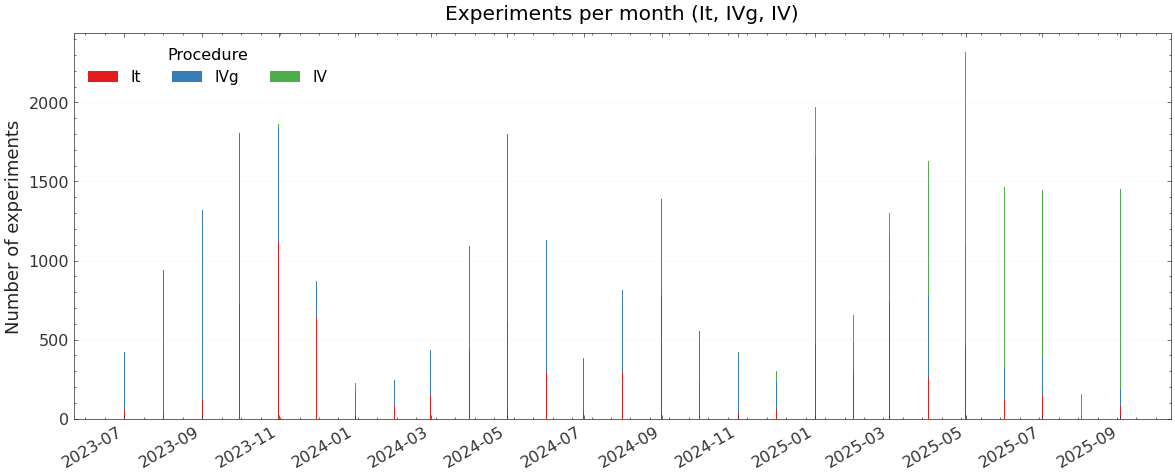

In [ ]:

PROCS = ["IVg","IV", "It"]  # pick the types you want

# 1) aggregate: monthly counts per proc
lf = pl.scan_parquet("warehouse/experiments/**/part-*.parquet", extra_columns="ignore")

counts = (
    lf.with_columns(pl.col("start_dt").dt.truncate("1mo").alias("month"))
      .filter(pl.col("start_dt") >= dt.datetime(2023, 1, 1))
      .filter(pl.col("proc").is_in(PROCS))
      .group_by(["month", "proc"])
      .agg(pl.len().alias("n"))
      .sort("month")
      .collect()
)

# 2) pivot -> wide
pivot = (
    counts.pivot(values="n", index="month", columns="proc", aggregate_function="sum")
          .fill_null(0)
          .sort("month")
)

x = pivot.get_column("month").to_list()
procs = [c for c in pivot.columns if c != "month"]
y_by_proc = {p: pivot.get_column(p).to_list() for p in procs}

# 3) stacked bar plot (datetime-aware x)
fig, ax = plt.subplots(figsize=(12, 5))

bottom = [0]*len(x)
for p in procs:
    vals = y_by_proc[p]
    ax.bar(x, vals, bottom=bottom, label=p)
    bottom = [b+v for b, v in zip(bottom, vals)]

# cosmetics
ax.set_title(f"Experiments per month ({', '.join(procs)})", pad=10)
ax.set_ylabel("Number of experiments")
ax.grid(axis="y", alpha=0.25)
ax.legend(title="Procedure", ncols=len(procs), frameon=False, loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

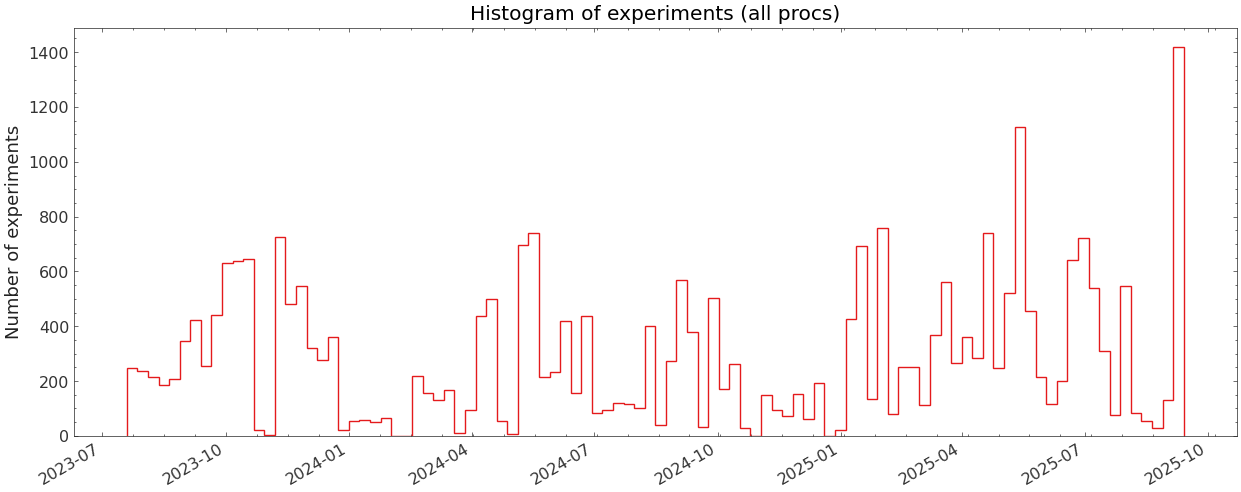

In [ ]:


lf = pl.scan_parquet("warehouse/experiments/**/part-*.parquet", extra_columns="ignore")

# filter only some procs, and from 2023 onwards
df = (
    lf.filter(pl.col("proc").is_in(["IVg","It","IV","VVg"]))
      .filter(pl.col("start_dt") >= pl.datetime(2023,1,1))
      .select("proc", "start_dt")
      .collect()
)


dates = df["start_dt"].to_list()

fig, ax = plt.subplots(figsize=(15,6))
ax.hist(dates, bins=100, histtype="step")

ax.set_ylabel("Number of experiments")
ax.set_title("Histogram of experiments (all procs)")
fig.autofmt_xdate()
plt.show()






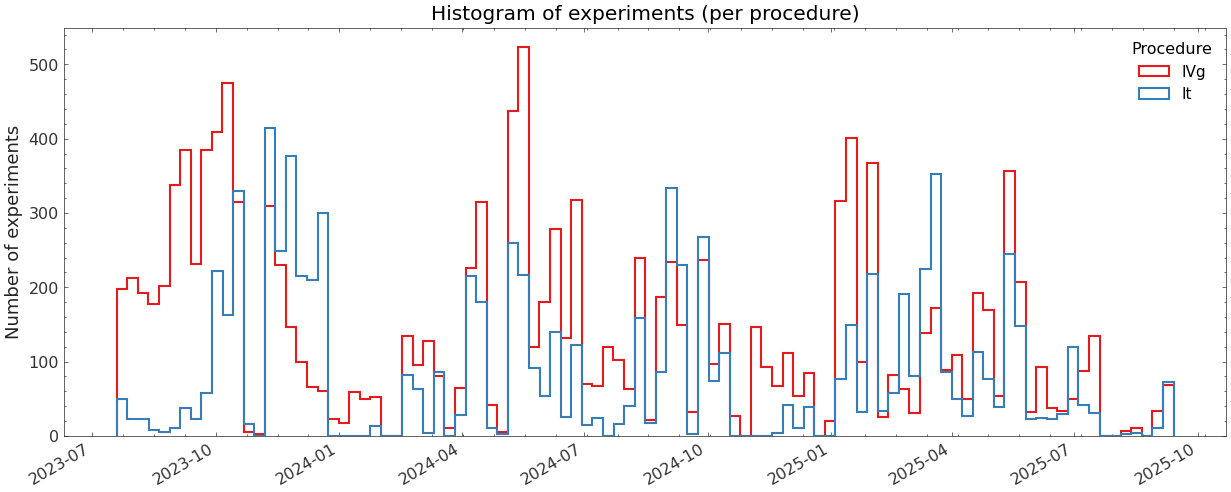

In [ ]:
procs = ["IVg","It"]

fig, ax = plt.subplots(figsize=(15,6))

for p in procs:
    dates = df.filter(pl.col("proc")==p)["start_dt"].to_list()
    ax.hist(
        dates,
        bins=100,
        histtype="step",      # 👈 only edges, no fill
        linewidth=1.5,        # thicker lines for clarity
        label=p
    )

ax.set_ylabel("Number of experiments")
ax.set_title("Histogram of experiments (per procedure)")
ax.legend(title="Procedure")
fig.autofmt_xdate()
plt.show()


In [ ]:
procs = ["VVg"]

fig, ax = plt.subplots(figsize=(15,6))
for p in procs:
    dates = df.filter(pl.col("proc")==p)["start_dt"].to_list()
    ax.hist(
        dates,
        bins=100,
        histtype="step",      # 👈 only edges, no fill
        linewidth=1.5,        # thicker lines for clarity
        label=p
    )

ax.set_ylabel("Number of experiments")
ax.set_title("Histogram of experiments (per procedure)")
ax.legend(title="Procedure")
fig.autofmt_xdate()
plt.show()


NameError: name 'plt' is not defined

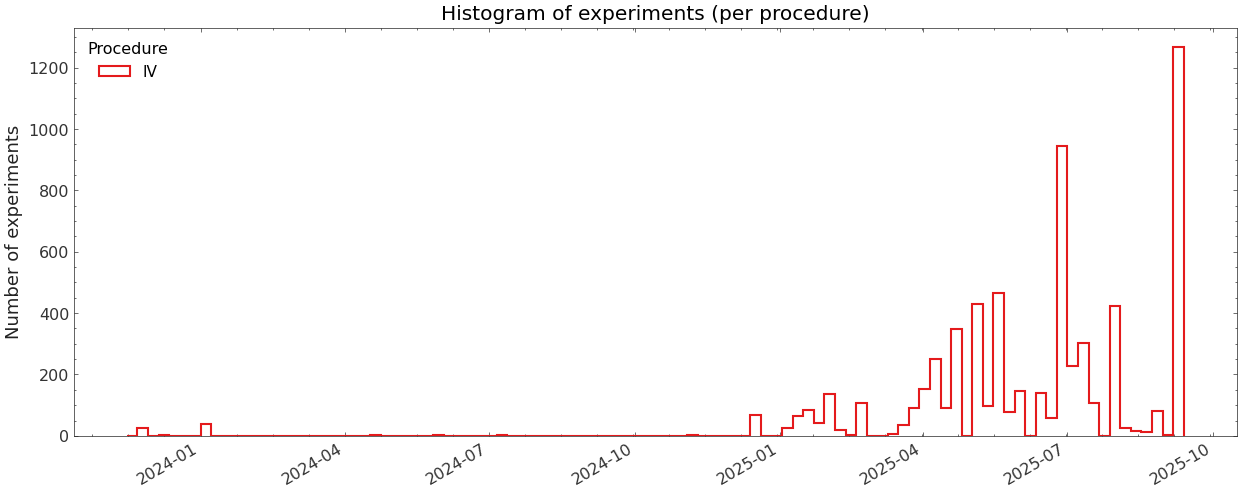

In [ ]:
procs = ["IV"]

fig, ax = plt.subplots(figsize=(15,6))
for p in procs:
    dates = df.filter(pl.col("proc")==p)["start_dt"].to_list()
    ax.hist(
        dates,
        bins=100,
        histtype="step",      # 👈 only edges, no fill
        linewidth=1.5,        # thicker lines for clarity
        label=p
    )
ax.set_ylabel("Number of experiments")
ax.set_title("Histogram of experiments (per procedure)")
ax.legend(title="Procedure")
fig.autofmt_xdate()
plt.show()

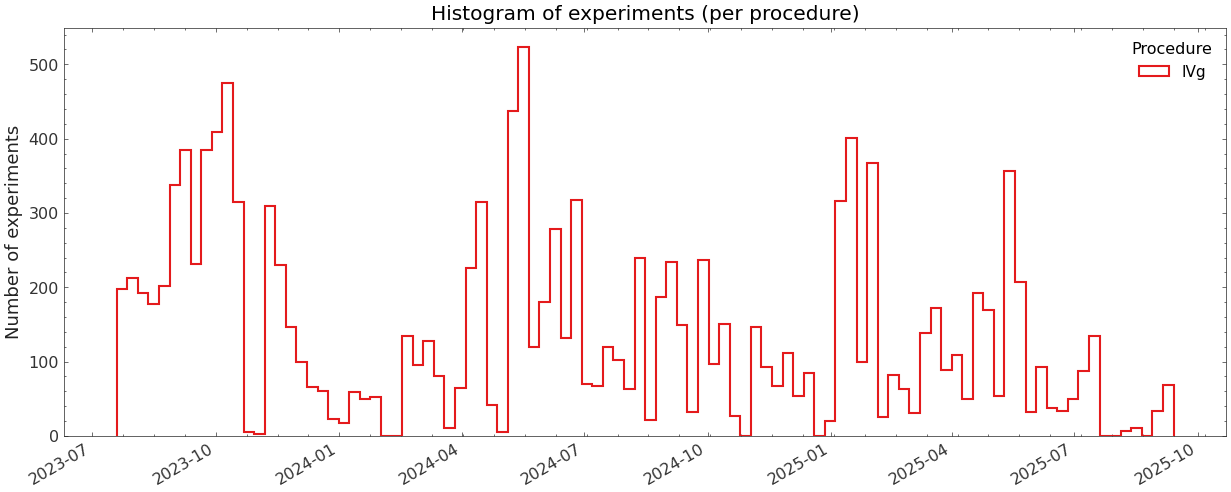

In [ ]:
procs = ["IVg"]

fig, ax = plt.subplots(figsize=(15,6))
for p in procs:
    dates = df.filter(pl.col("proc")==p)["start_dt"].to_list()
    ax.hist(
        dates,
        bins=100,
        histtype="step",      # 👈 only edges, no fill
        linewidth=1.5,        # thicker lines for clarity
        label=p
    )
ax.set_ylabel("Number of experiments")
ax.set_title("Histogram of experiments (per procedure)")
ax.legend(title="Procedure")
fig.autofmt_xdate()
plt.show()

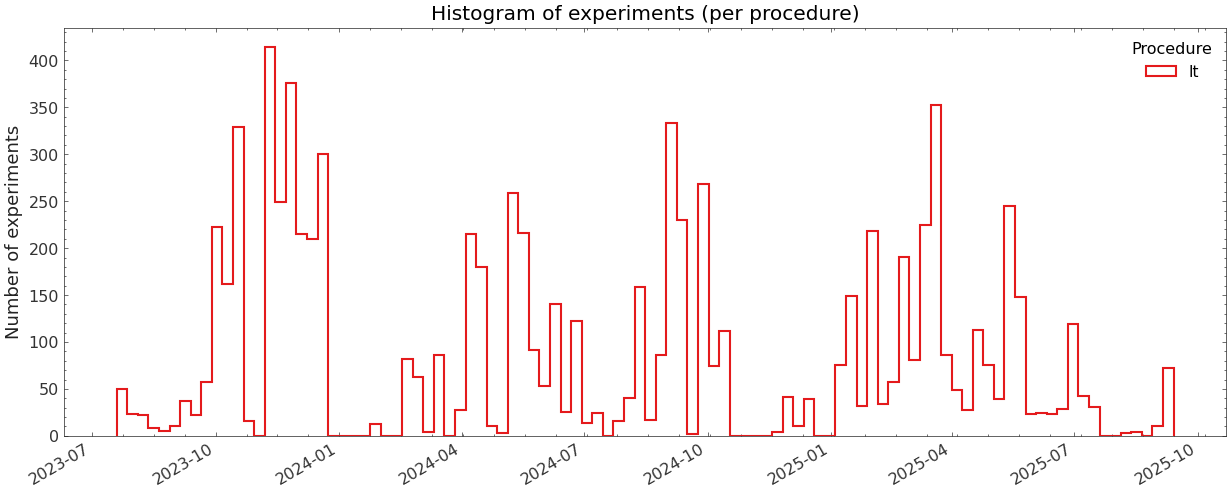

In [ ]:
procs = ["It"]

fig, ax = plt.subplots(figsize=(15,6))
for p in procs:
    dates = df.filter(pl.col("proc")==p)["start_dt"].to_list()
    ax.hist(
        dates,
        bins=100,
        histtype="step",      # 👈 only edges, no fill
        linewidth=1.5,        # thicker lines for clarity
        label=p
    )
ax.set_ylabel("Number of experiments")
ax.set_title("Histogram of experiments (per procedure)")
ax.legend(title="Procedure")
fig.autofmt_xdate()
plt.show()